In [294]:
import pickle
import numpy as np

with open('../F1F4_ids_rest_nback_3.bin', 'rb') as f:
    F1F4_ids_rest_nback = pickle.load(f)
    
for key in F1F4_ids_rest_nback:
    print(key)
    
F1_train_ids = F1F4_ids_rest_nback['F1_train_ids']
F4_train_ids = F1F4_ids_rest_nback['F4_train_ids']
F1_test_ids = F1F4_ids_rest_nback['F1_test_ids']
F4_test_ids = F1F4_ids_rest_nback['F4_test_ids']

print(F1_train_ids[0])

F1_train_ids
F4_train_ids
F1_test_ids
F4_test_ids
[859 888]


In [295]:
# Load F1,F4 train and test, resting state and nback

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

F1_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_test_ids]

F1_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_test_ids]

print(len(F1_train_rest))
print(len(F4_train_rest))
print(len(F1_test_rest))
print(len(F4_test_rest))

print(len(F1_train_nback))
print(len(F4_train_nback))
print(len(F1_test_nback))
print(len(F4_test_nback))

74
93
24
30
74
93
24
30


In [296]:
# Normalize all datasets

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])

normalizeSubjects(F1_train_rest)
normalizeSubjects(F4_train_rest)
normalizeSubjects(F1_test_rest)
normalizeSubjects(F4_test_rest)

normalizeSubjects(F1_train_nback)
normalizeSubjects(F4_train_nback)
normalizeSubjects(F1_test_nback)
normalizeSubjects(F4_test_nback)

print('Normalization complete')

Normalization complete


In [297]:
# Labels

y_F1F4_train_rest = np.hstack([np.zeros([len(F1_train_rest)]), np.ones([len(F4_train_rest)])])
y_F1F4_test_rest = np.hstack([np.zeros([len(F1_test_rest)]), np.ones([len(F4_test_rest)])])

# Training and test sets

F1F4_train_rest = F1_train_rest + F4_train_rest
F1F4_test_rest = F1_test_rest + F4_test_rest
F1F4_train_nback = F1_train_nback + F4_train_nback
F1F4_test_nback = F1_test_nback + F4_test_nback

# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

F1F4_train_rest_torch = [torch.from_numpy(subj.T).float() for subj in F1F4_train_rest]
F1F4_test_rest_torch = [torch.from_numpy(subj.T).float() for subj in F1F4_test_rest]
F1F4_train_nback_torch = [torch.from_numpy(subj.T).float() for subj in F1F4_train_nback]
F1F4_test_nback_torch = [torch.from_numpy(subj.T).float() for subj in F1F4_test_nback]

print('Torch complete')

Torch complete


In [298]:
def getKLDiv(mu, logvar):
    return -0.5*torch.sum(1 + logvar - mu**2 - logvar.exp())

def corrcoef(x1):
    x1c = x1 - torch.mean(x1, 0, keepdim=True)
    x1n = x1c/torch.sqrt(torch.sum(x1c*x1c, 0, keepdim=True))
    return x1n.T@x1n

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc11 = nn.Linear(264,132)
        self.fc12 = nn.Linear(132,120)
        self.fc13 = nn.Linear(60,132)
        self.fc14 = nn.Linear(132,264)
        
        self.fc21 = nn.Linear(264,132)
        self.fc22 = nn.Linear(132,120)
        self.fc23 = nn.Linear(60,132)
        self.fc24 = nn.Linear(132,264)
        
    def getMuLogVar(self, x, modality):
        if modality == 'rest':
            fc1 = self.fc11
            fc2 = self.fc12
        else:
            fc1 = self.fc21
            fc2 = self.fc22
        x = F.relu(fc1(x))
        x = fc2(x)
        mu = x[:,:60]
        logvar = x[:,60:]
        return mu, logvar
    
    def encode(self, x, modality):
        mu, logvar = self.getMuLogVar(x, modality)
        KLDiv = getKLDiv(mu, logvar)
        eps = torch.randn(60)
        x = mu + torch.sqrt(logvar.exp())*eps
        return x, KLDiv
    
    def decode(self, x, modality):
        if modality == 'rest':
            fc3 = self.fc13
            fc4 = self.fc14
        else:
            fc3 = self.fc23
            fc4 = self.fc24
        x = F.relu(fc3(x))
        x = fc4(x)
        return x

    def forward(self, x):
        x1, KLDiv1, x1cor = None, None, None
        x2, KLDiv2, x2cor = None, None, None
        if x[0] is not None:
            x1, KLDiv1 = self.encode(x[0], 'rest') 
            x1cor = corrcoef(x1)
            x1 = self.decode(x1, 'rest')
        if x[1] is not None:
            x2, KLDiv2 = self.encode(x[1], 'nback') 
            x2cor = corrcoef(x2) 
            x2 = self.decode(x2, 'nback') 
        return x1, x2, KLDiv1, KLDiv2, x1cor, x2cor

In [364]:
vae = VAE()
optim = torch.optim.SGD(vae.parameters(), momentum=0.5, lr=5e-6)

In [365]:
N = len(F1F4_train_rest)-1
running = 0

for epoch in range(10000):
    # Choose subject
    idx = random.randint(0,N)
    subj1 = F1F4_train_rest_torch[idx]
    subj2 = F1F4_train_nback_torch[idx]
    
    # Train
    optim.zero_grad()
    recon1, recon2, KLDiv1, KLDiv2, x1cor, x2cor = vae([subj1, subj2])
    loss = torch.sum((subj1-recon1)**2) + torch.sum((subj2-recon2)**2) + 0.2*torch.sum((x1cor - x2cor)**2) + KLDiv1 + KLDiv2 
    loss.backward(retain_graph=True)
    
    # Backpropagate
    optim.step()
    
    running += loss

    # print statistics
    if epoch % 200 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, running/200))
        running = 0

print('Finished Training')

[epoch 0] loss: 503.424
[epoch 200] loss: 79746.414
[epoch 400] loss: 70383.078
[epoch 600] loss: 68523.602
[epoch 800] loss: 65742.797
[epoch 1000] loss: 64098.496
[epoch 1200] loss: 62945.898
[epoch 1400] loss: 62058.020
[epoch 1600] loss: 61284.629
[epoch 1800] loss: 60791.766
[epoch 2000] loss: 61030.387
[epoch 2200] loss: 60092.066
[epoch 2400] loss: 60003.969
[epoch 2600] loss: 58863.148
[epoch 2800] loss: 58996.480
[epoch 3000] loss: 58139.324
[epoch 3200] loss: 58942.461
[epoch 3400] loss: 57219.828
[epoch 3600] loss: 58684.199
[epoch 3800] loss: 57657.500
[epoch 4000] loss: 57666.879
[epoch 4200] loss: 56459.566
[epoch 4400] loss: 56499.500
[epoch 4600] loss: 57168.719
[epoch 4800] loss: 56437.160
[epoch 5000] loss: 57400.172
[epoch 5200] loss: 56988.809
[epoch 5400] loss: 56373.047
[epoch 5600] loss: 55550.906
[epoch 5800] loss: 56594.480
[epoch 6000] loss: 55824.262
[epoch 6200] loss: 56345.363
[epoch 6400] loss: 56144.480
[epoch 6600] loss: 57055.047
[epoch 6800] loss: 5630

In [384]:
from sklearn.linear_model import LogisticRegression

X_F1F4_train_cor = np.zeros([len(F1F4_train_rest), 2*60*60])
X_F1F4_test_cor = np.zeros([len(F1F4_test_rest), 2*60*60])

for i in range(len(F1F4_train_rest)):
    subj1 = F1F4_train_rest_torch[i]
    subj2 = F1F4_train_nback_torch[i]
    recon1, recon2, KLDiv1, KLDiv2, x1cor, x2cor = vae([subj1, subj2])
    X_F1F4_train_cor[i,:] = np.hstack([x1cor.detach().numpy().flatten(), x2cor.detach().numpy().flatten()])
    #X_F1F4_train_cor[i,:] = x2cor.detach().numpy().flatten()
    
for i in range(len(F1F4_test_rest)):
    subj1 = F1F4_test_rest_torch[i]
    subj2 = F1F4_test_nback_torch[i]
    recon1, recon2, KLDiv1, KLDiv2, x1cor, x2cor = vae([subj1, subj2])
    X_F1F4_test_cor[i,:] = np.hstack([x1cor.detach().numpy().flatten(), x2cor.detach().numpy().flatten()])
    #X_F1F4_test_cor[i,:] = x2cor.detach().numpy().flatten()
    
print('Complete')

Complete


In [385]:
# Logistic regression

clf = LogisticRegression(max_iter=500).fit(X_F1F4_train_cor, y_F1F4_train_rest)
print('Finished')

Finished


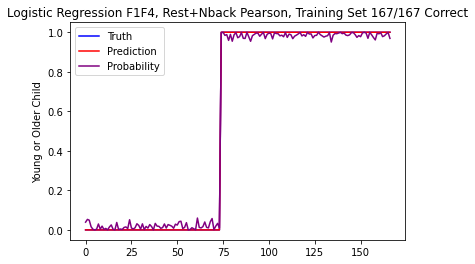

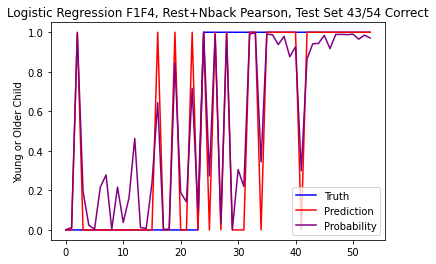

In [386]:
# Display results

import matplotlib.pyplot as plt

def show_results(y_true, y_predict, y_prob=None, title="", label="Young or Older Child"):
    nCorrect = 0
    for i in range(len(y_true)):
        if y_true[i] == y_predict[i]:
            nCorrect += 1

    fig, ax = plt.subplots()
    
    ax.plot(y_true, color='blue', label='Truth')
    ax.plot(y_predict, color='red', label='Prediction')
    
    if y_prob is not None:
        ax.plot(y_prob[:,1], color='purple', label='Probability')
        
    ax.set_title(title + ' {:d}/{:d} Correct'.format(nCorrect, len(y_true)))
    ax.set_ylabel(label)
    ax.legend()

    plt.show()
    
y1 = clf.predict(X_F1F4_train_cor)
y1_prob = clf.predict_proba(X_F1F4_train_cor)
y1_test = clf.predict(X_F1F4_test_cor)
y1_test_prob = clf.predict_proba(X_F1F4_test_cor)

show_results(y_F1F4_train_rest, y1, y1_prob, 'Logistic Regression F1F4, Rest+Nback Pearson, Training Set')
show_results(y_F1F4_test_rest, y1_test, y1_test_prob, 'Logistic Regression F1F4, Rest+Nback Pearson, Test Set')

In [387]:
class MLPSingle(nn.Module):
    def __init__(self):
        super(MLPSingle, self).__init__()
        self.fc1 = nn.Linear(2*60*60,100)
        self.fc2 = nn.Linear(100,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [388]:
mlpSingle = MLPSingle()
optimSingle = torch.optim.SGD(mlpSingle.parameters(), momentum=0.5, lr=5e-4)
print('Single complete')

Single complete


In [391]:
N = len(X_F1F4_train_cor)-1
running = 0

for epoch in range(10000):
    # Choose subject
    idx = random.randint(0,N)
    subj = torch.from_numpy(X_F1F4_train_cor[idx,:]).float()
    truth = round(y_F1F4_train_rest[idx])
    
    # Train
    optimSingle.zero_grad()
    label = mlpSingle(subj)
    loss = -label[truth] + torch.log(torch.sum(torch.exp(label)))
    loss.backward()
    
    # Backpropagate
    optimSingle.step()
    
    running += loss

    # print statistics
    if epoch % 100 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, running/100))
        running = 0

print('Finished Training')

[epoch 0] loss: 0.000
[epoch 100] loss: 0.013
[epoch 200] loss: 0.013
[epoch 300] loss: 0.012
[epoch 400] loss: 0.011
[epoch 500] loss: 0.011
[epoch 600] loss: 0.012
[epoch 700] loss: 0.012
[epoch 800] loss: 0.011
[epoch 900] loss: 0.013
[epoch 1000] loss: 0.011
[epoch 1100] loss: 0.011
[epoch 1200] loss: 0.011
[epoch 1300] loss: 0.011
[epoch 1400] loss: 0.010
[epoch 1500] loss: 0.011
[epoch 1600] loss: 0.012
[epoch 1700] loss: 0.011
[epoch 1800] loss: 0.012
[epoch 1900] loss: 0.010
[epoch 2000] loss: 0.010
[epoch 2100] loss: 0.013
[epoch 2200] loss: 0.011
[epoch 2300] loss: 0.008
[epoch 2400] loss: 0.008
[epoch 2500] loss: 0.012
[epoch 2600] loss: 0.009
[epoch 2700] loss: 0.007
[epoch 2800] loss: 0.008
[epoch 2900] loss: 0.011
[epoch 3000] loss: 0.010
[epoch 3100] loss: 0.009
[epoch 3200] loss: 0.010
[epoch 3300] loss: 0.009
[epoch 3400] loss: 0.007
[epoch 3500] loss: 0.007
[epoch 3600] loss: 0.009
[epoch 3700] loss: 0.008
[epoch 3800] loss: 0.008
[epoch 3900] loss: 0.007
[epoch 4000]

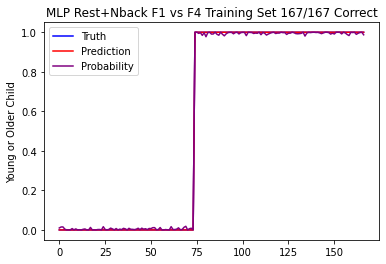

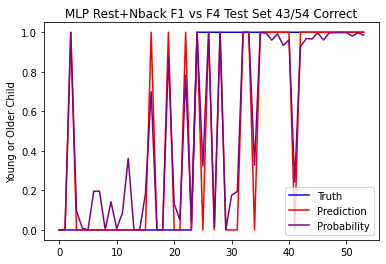

In [392]:
def getResults(mlp, X_subjects):
    y_predict = []
    y_prob = np.zeros([X_subjects.shape[0],2])
    for i in range(X_subjects.shape[0]):
        subj = torch.from_numpy(X_subjects[i]).float()
        label = mlp(subj)
        idx = np.argmax(label.detach().numpy())
        y_predict.append(idx)
        p = torch.exp(label[idx])/torch.sum(torch.exp(label))
        if idx == 0:
            y_prob[i,1] = 1-p
        else:
            y_prob[i,1] = p
        i += 1
    return y_predict, y_prob

y1, y1p = getResults(mlpSingle, X_F1F4_train_cor)
y2, y2p = getResults(mlpSingle, X_F1F4_test_cor)

show_results(y_F1F4_train_rest, y1, y1p, "MLP Rest+Nback F1 vs F4 Training Set")
show_results(y_F1F4_test_rest, y2, y2p, "MLP Rest+Nback F1 vs F4 Test Set")